# Flagship Cluster Posterior Analysis

This notebook analyzes the posterior distributions from SBI applied to the Euclid Flagship cluster catalogue.

The posteriors are trained using the `run_sbi.py` script with the following parameters:
- Omega_m: matter density
- sigma8: amplitude of matter fluctuations
- alpha_lambda: mass-richness relation normalization
- beta_lambda: mass-richness relation slope

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from pathlib import Path
import pickle
import torch

# Add project root to path
project_root = Path.cwd().parent.parent
sys.path.insert(0, str(project_root))

print(f"Project root: {project_root}")

Project root: /pbs/home/c/cmurray/cluster_likelihood


## 1. Load Posterior Estimator

In [2]:
# Path to the saved posterior estimator
posterior_path = Path('/sps/euclid/Users/cmurray/clusters_likelihood/posterior_estimator_flagship.pkl')

# Load the posterior
print(f"Loading posterior from: {posterior_path}")
with open(posterior_path, 'rb') as handle:
    posterior = pickle.load(handle)

print("Posterior loaded successfully!")

Loading posterior from: /sps/euclid/Users/cmurray/clusters_likelihood/posterior_estimator_flagship.pkl


/sps/euclid/Users/cmurray/miniconda3/envs/capish/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Posterior loaded successfully!


## 2. Load Flagship Observed Data

In [3]:
# Load Flagship summary statistics
flagship_path = project_root / 'euclid_flagship_simulations' / 'flagship_cluster_catalogue_summary_statstics_DES_MoR.npy'
flagship_data = np.load(flagship_path, allow_pickle=True).item()

print("Flagship data keys:", flagship_data.keys())

# Use M200b definition (matching the config)
flagship_counts = flagship_data['count_with_m200b_def']
flagship_mean_masses = flagship_data['mean_log10m200b']

# Create observed data vector (counts + masses flattened)
observed_counts = flagship_counts.flatten()
observed_masses = flagship_mean_masses.flatten()
observed_data = np.concatenate([observed_counts, observed_masses])
observed_data_tensor = torch.tensor(observed_data, dtype=torch.float32)

print(f"\nObserved data vector shape: {observed_data.shape}")
print(f"Number of count bins: {len(observed_counts)}")
print(f"Number of mass bins: {len(observed_masses)}")

Flagship data keys: dict_keys(['count_with_m200b_def', 'mean_log10m200b', 'count_with_m200c_def', 'mean_log10m200c'])

Observed data vector shape: (40,)
Number of count bins: 20
Number of mass bins: 20


## 3. Sample Posterior

In [4]:
# Number of posterior samples to draw
num_samples = 50000

print(f"Drawing {num_samples} samples from the posterior...")
posterior_samples = posterior.sample((num_samples,), x=observed_data_tensor)
posterior_samples_np = posterior_samples.cpu().numpy()

print(f"\nPosterior samples shape: {posterior_samples_np.shape}")
print("Done!")

Drawing 50000 samples from the posterior...


52384it [00:00, 73586.55it/s]                           


Posterior samples shape: (50000, 4)
Done!


## 4. Analyze Posterior Statistics

In [5]:
# Parameter names and labels
param_names = ['Omega_m', 'sigma8', 'alpha_lambda', 'beta_lambda']
param_labels = [r'$\Omega_m$', r'$\sigma_8$', r'$\alpha_\lambda$', r'$\beta_\lambda$']

# Fiducial values (from config)
fiducial_values = [0.319, 0.813, -9.348, 0.75]

# Calculate percentiles
percentiles = np.percentile(posterior_samples_np, [16, 50, 84], axis=0)

print("\n" + "="*70)
print("POSTERIOR CREDIBLE INTERVALS (68% confidence)")
print("="*70)
print(f"{'Parameter':<20} {'Median':<15} {'68% CI':<25} {'Fiducial':<15}")
print("-"*70)

for i, (name, label, fid) in enumerate(zip(param_names, param_labels, fiducial_values)):
    p16, p50, p84 = percentiles[:, i]
    err_low = p50 - p16
    err_high = p84 - p50
    
    # Calculate how many sigma away from fiducial
    avg_err = (err_low + err_high) / 2
    n_sigma = abs(p50 - fid) / avg_err if avg_err > 0 else 0
    
    print(f"{name:<20} {p50:>6.3f}         +{err_high:<6.3f} -{err_low:<6.3f}      {fid:>6.3f} ({n_sigma:.1f}σ)")

print("="*70)


POSTERIOR CREDIBLE INTERVALS (68% confidence)
Parameter            Median          68% CI                    Fiducial       
----------------------------------------------------------------------
Omega_m               0.147         +0.068  -0.033        0.319 (3.4σ)
sigma8                0.797         +0.074  -0.085        0.813 (0.2σ)
alpha_lambda         -9.628         +1.362  -1.237       -9.348 (0.2σ)
beta_lambda           0.770         +0.086  -0.097        0.750 (0.2σ)


## 5. Corner Plot

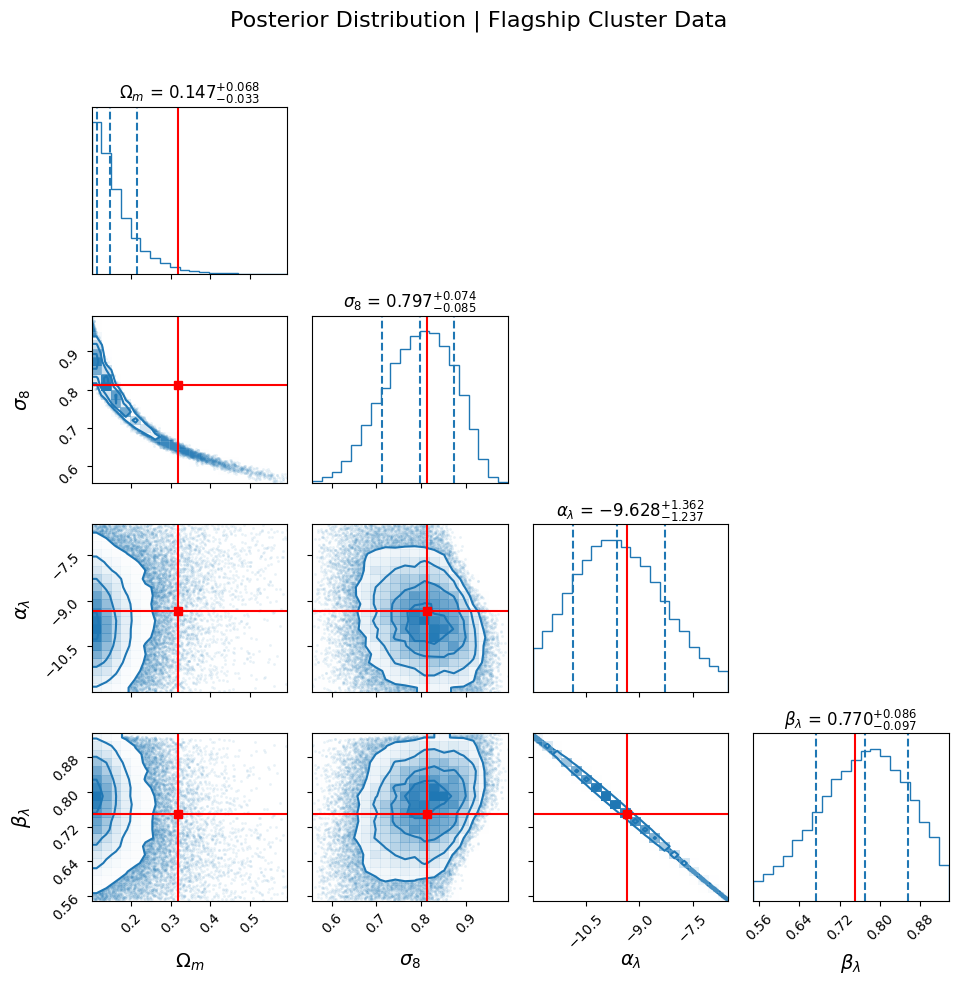


Corner plot saved to: /pbs/home/c/cmurray/cluster_likelihood/notebooks/calum/flagship_posterior_corner.png


In [6]:
try:
    import corner
except ImportError:
    print("Installing corner package...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "corner"])
    import corner

# Create corner plot
fig = corner.corner(
    posterior_samples_np,
    labels=param_labels,
    truths=fiducial_values,
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_fmt='.3f',
    color='#1f77b4',
    truth_color='red',
    label_kwargs={'fontsize': 14},
    title_kwargs={'fontsize': 12}
)

fig.suptitle('Posterior Distribution | Flagship Cluster Data', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Save the figure
output_fig_path = Path.cwd() / 'flagship_posterior_corner.png'
fig.savefig(output_fig_path, dpi=300, bbox_inches='tight')
print(f"\nCorner plot saved to: {output_fig_path}")

## 6. Individual Parameter Distributions

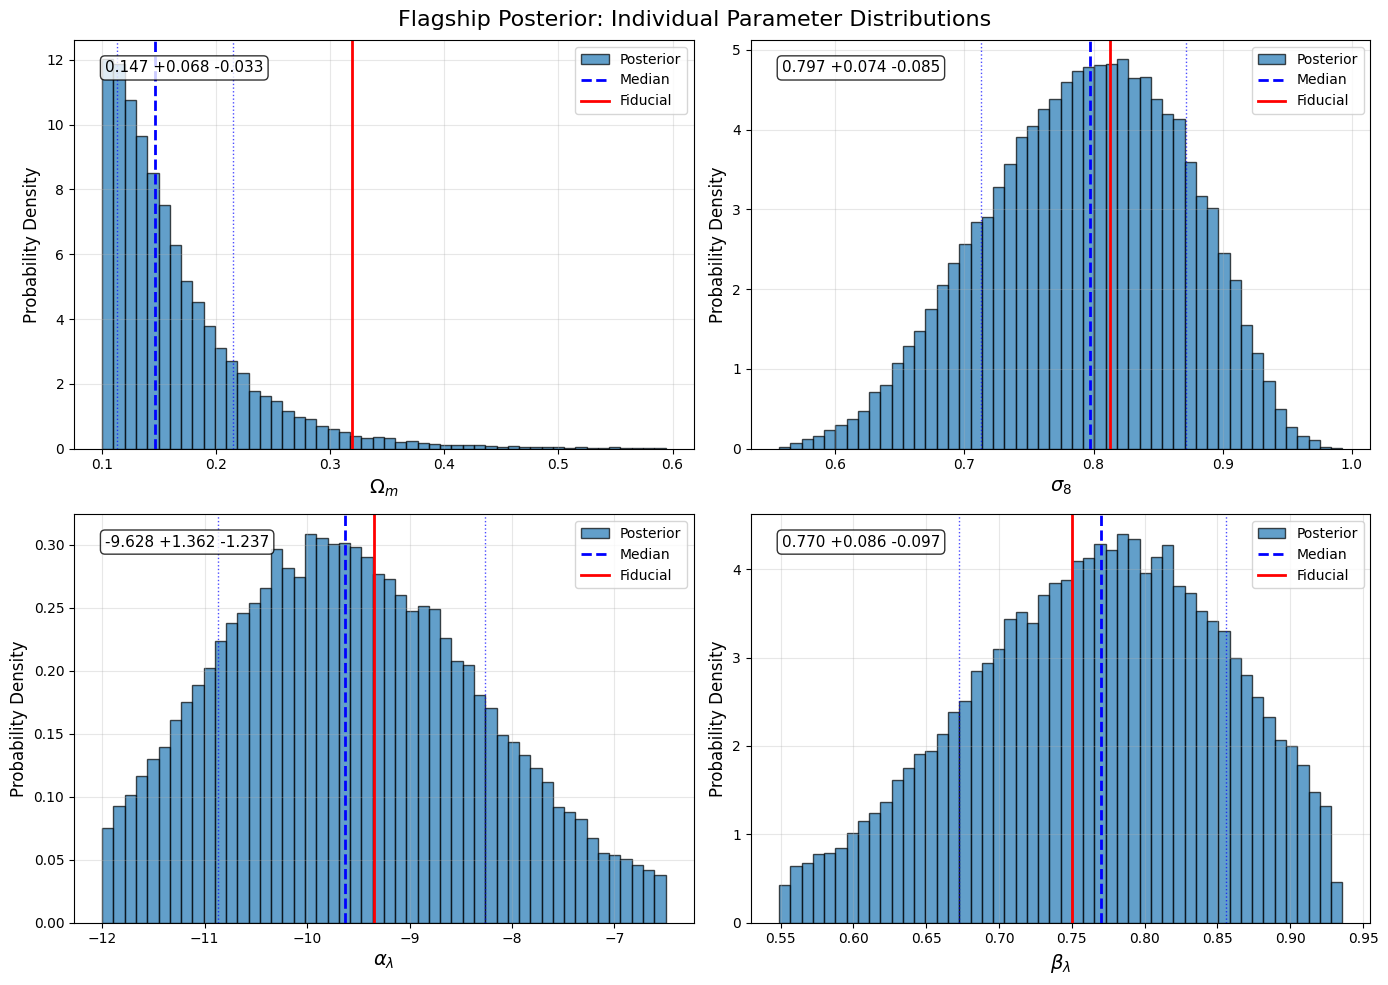


1D distributions saved to: /pbs/home/c/cmurray/cluster_likelihood/notebooks/calum/flagship_posterior_1d.png


In [7]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, (name, label, fid, ax) in enumerate(zip(param_names, param_labels, fiducial_values, axes)):
    # Plot histogram
    ax.hist(posterior_samples_np[:, i], bins=50, alpha=0.7, color='#1f77b4', 
            edgecolor='black', density=True, label='Posterior')
    
    # Add vertical lines for percentiles
    p16, p50, p84 = percentiles[:, i]
    ax.axvline(p50, color='blue', linewidth=2, linestyle='--', label='Median')
    ax.axvline(p16, color='blue', linewidth=1, linestyle=':', alpha=0.7)
    ax.axvline(p84, color='blue', linewidth=1, linestyle=':', alpha=0.7)
    
    # Add fiducial value
    ax.axvline(fid, color='red', linewidth=2, label='Fiducial')
    
    # Labels and formatting
    ax.set_xlabel(label, fontsize=14)
    ax.set_ylabel('Probability Density', fontsize=12)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Add text with credible interval
    err_low = p50 - p16
    err_high = p84 - p50
    text = f"{p50:.3f} +{err_high:.3f} -{err_low:.3f}"
    ax.text(0.05, 0.95, text, transform=ax.transAxes, 
            verticalalignment='top', fontsize=11,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.suptitle('Flagship Posterior: Individual Parameter Distributions', fontsize=16)
plt.tight_layout()
plt.show()

# Save the figure
output_fig_path = Path.cwd() / 'flagship_posterior_1d.png'
fig.savefig(output_fig_path, dpi=300, bbox_inches='tight')
print(f"\n1D distributions saved to: {output_fig_path}")

## 7. Correlation Matrix

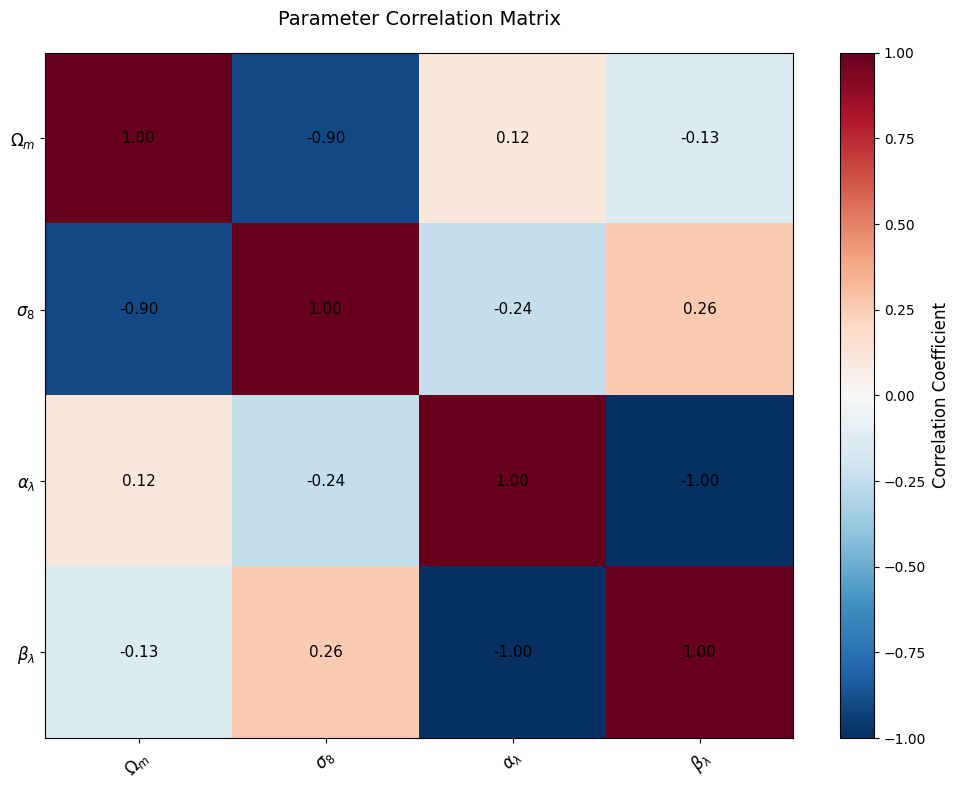


CORRELATION MATRIX
                       Omega_m         sigma8   alpha_lambda    beta_lambda
----------------------------------------------------------------------
        Omega_m          1.000         -0.905          0.117         -0.135
         sigma8         -0.905          1.000         -0.242          0.261
   alpha_lambda          0.117         -0.242          1.000         -1.000
    beta_lambda         -0.135          0.261         -1.000          1.000


In [8]:
# Calculate correlation matrix
corr_matrix = np.corrcoef(posterior_samples_np.T)

# Plot correlation matrix
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(corr_matrix, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Correlation Coefficient', fontsize=12)

# Set ticks and labels
ax.set_xticks(range(len(param_names)))
ax.set_yticks(range(len(param_names)))
ax.set_xticklabels(param_labels, fontsize=12)
ax.set_yticklabels(param_labels, fontsize=12)

# Rotate x labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Add correlation values as text
for i in range(len(param_names)):
    for j in range(len(param_names)):
        text = ax.text(j, i, f"{corr_matrix[i, j]:.2f}",
                      ha="center", va="center", color="black", fontsize=11)

ax.set_title('Parameter Correlation Matrix', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# Print correlation matrix
print("\n" + "="*70)
print("CORRELATION MATRIX")
print("="*70)
print(f"{'':>15}", end="")
for name in param_names:
    print(f"{name:>15}", end="")
print()
print("-"*70)

for i, name in enumerate(param_names):
    print(f"{name:>15}", end="")
    for j in range(len(param_names)):
        print(f"{corr_matrix[i, j]:>15.3f}", end="")
    print()
print("="*70)

## 8. Posterior Predictive Check

Generate predictions using posterior samples and compare with observed data.

In [9]:
from modules.simulation import UniverseSimulator
import configparser

# Load configuration
config_path = project_root / 'config' / 'capish.ini'
config = configparser.ConfigParser()
config.read(config_path)

# Initialize simulator
variable_params = ['Omega_m', 'sigma8', 'alpha_lambda', 'beta_lambda']
simulator = UniverseSimulator(
    default_config_path=str(config_path),
    variable_params_names=variable_params
)

print("Simulator initialized for posterior predictive check")

Simulator initialized for posterior predictive check


In [10]:
# Generate predictions from posterior samples
n_predictive_samples = 100  # Use subset for speed
print(f"Generating {n_predictive_samples} posterior predictive samples...")

# Randomly select samples from posterior
indices = np.random.choice(len(posterior_samples_np), size=n_predictive_samples, replace=False)
predictive_samples = posterior_samples_np[indices]

# Fixed parameters (not being inferred)
fixed_gamma_lambda = 0.0
fixed_M_min = 134896288259.1656

# Run simulations
predictions = []
for i, theta in enumerate(predictive_samples):
    if (i + 1) % 20 == 0:
        print(f"  {i+1}/{n_predictive_samples} samples...")
    
    # Construct full parameter vector
    full_params = [
        float(theta[0]),  # Omega_m
        float(theta[1]),  # sigma8
        float(theta[2]),  # alpha_lambda
        float(theta[3]),  # beta_lambda
        fixed_gamma_lambda,
        fixed_M_min
    ]
    
    # Run simulation
    summary_stats = simulator.run_simulation(full_params)
    
    # Extract counts and masses (assuming tuple format)
    if isinstance(summary_stats, tuple):
        counts, masses = summary_stats
    else:
        # Old format: split flat array
        n_bins = len(summary_stats) // 2
        counts = summary_stats[:n_bins].reshape(5, 4)
        masses = summary_stats[n_bins:].reshape(5, 4)
    
    predictions.append({
        'counts': np.array(counts),
        'masses': np.array(masses)
    })

print("Posterior predictive samples generated!")

Generating 100 posterior predictive samples...


/pbs/home/c/cmurray/cluster_likelihood/modules/summary_statistics/summary_statistics.py:81: RuntimeWarning: invalid value encountered in divide
  return count_stat, np.log10((sum_w_mass_gamma_stat/sum_w_stat)**(1/self.Gamma))


  20/100 samples...
  40/100 samples...
  60/100 samples...
  80/100 samples...
  100/100 samples...
Posterior predictive samples generated!


In [11]:
# Calculate percentiles of predictions
pred_counts = np.array([p['counts'] for p in predictions])
pred_masses = np.array([p['masses'] for p in predictions])

counts_median = np.median(pred_counts, axis=0)
counts_p16 = np.percentile(pred_counts, 16, axis=0)
counts_p84 = np.percentile(pred_counts, 84, axis=0)

masses_median = np.median(pred_masses, axis=0)
masses_p16 = np.percentile(pred_masses, 16, axis=0)
masses_p84 = np.percentile(pred_masses, 84, axis=0)

# Binning info
richness_edges = np.array([20, 30, 50, 80, 130, 200])
redshift_edges = np.array([0.2, 0.3, 0.4, 0.8, 1.0])
richness_centers = (richness_edges[:-1] + richness_edges[1:]) / 2

n_richness_bins = len(richness_edges) - 1
n_redshift_bins = len(redshift_edges) - 1

colors = ['#7fb0ff', '#f7c394', '#bfe6b8', '#ffb3ba']
z_labels = [f'${redshift_edges[i]:.1f} < z < {redshift_edges[i+1]:.1f}$' 
            for i in range(n_redshift_bins)]

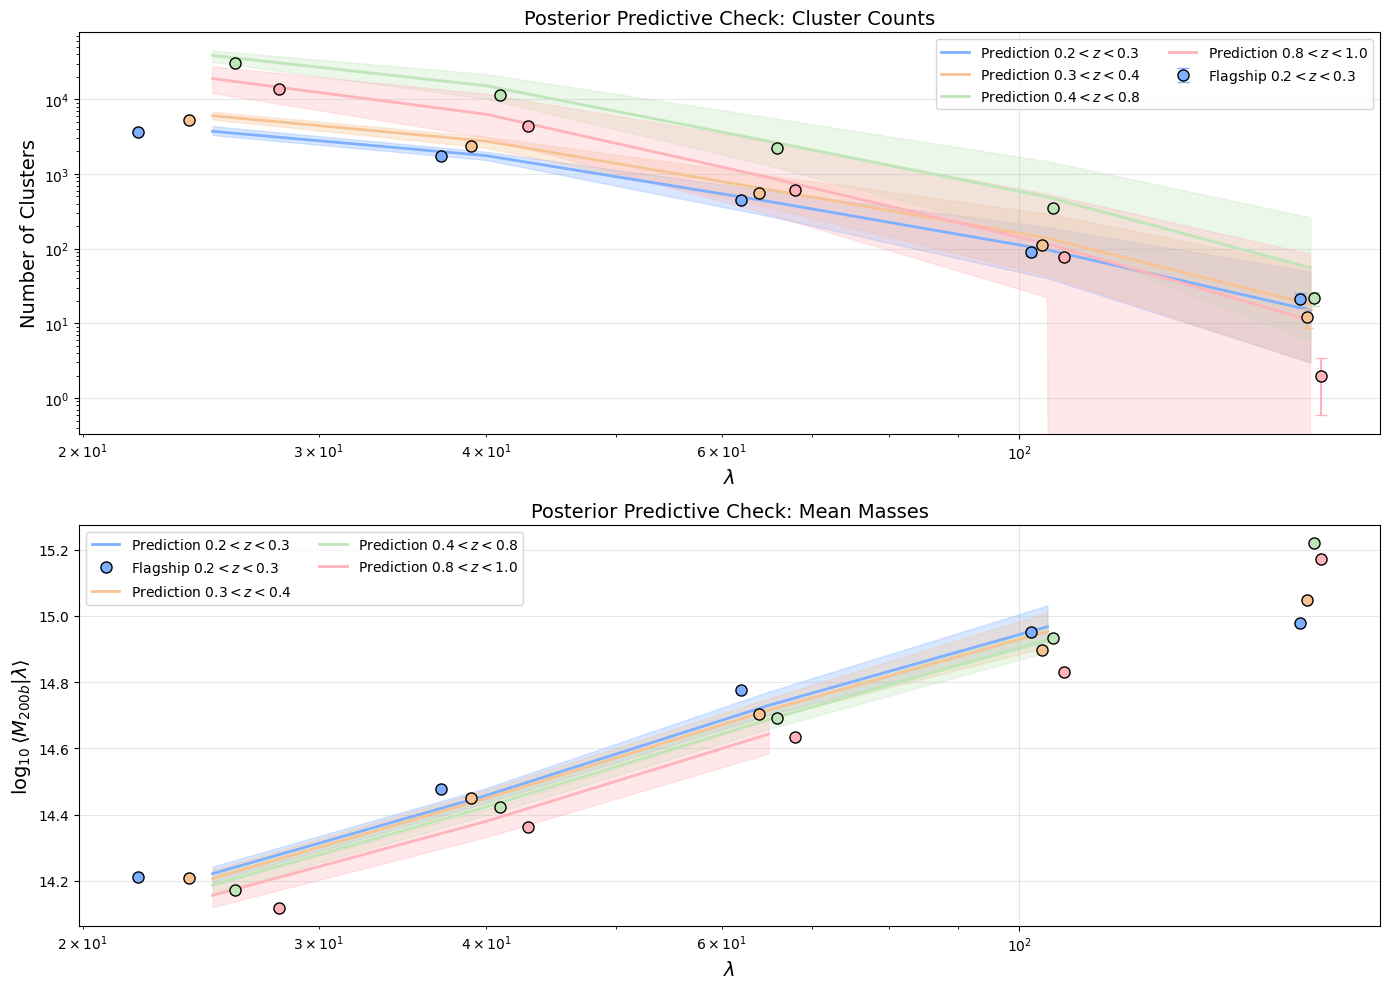


Posterior predictive check saved to: /pbs/home/c/cmurray/cluster_likelihood/notebooks/calum/flagship_posterior_predictive_check.png


In [12]:
# Plot posterior predictive check
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Counts
ax = axes[0]
for i in range(n_redshift_bins):
    # Plot posterior predictive median and credible interval
    ax.plot(richness_centers, counts_median[:, i], '-', color=colors[i], 
            linewidth=2, label=f'Prediction {z_labels[i]}')
    ax.fill_between(richness_centers, counts_p16[:, i], counts_p84[:, i],
                    color=colors[i], alpha=0.3)
    
    # Plot observed data
    count_errors = np.sqrt(np.maximum(flagship_counts[:, i], 1))
    ax.errorbar(richness_centers + (i-1.5)*2, flagship_counts[:, i], 
               yerr=count_errors, fmt='o', color=colors[i], 
               markeredgecolor='k', markersize=8, capsize=4, 
               label=f'Flagship {z_labels[i]}' if i == 0 else None, zorder=10)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\lambda$', fontsize=14)
ax.set_ylabel('Number of Clusters', fontsize=14)
ax.legend(fontsize=10, ncol=2)
ax.grid(True, alpha=0.3)
ax.set_title('Posterior Predictive Check: Cluster Counts', fontsize=14)

# Plot 2: Mean masses
ax = axes[1]
for i in range(n_redshift_bins):
    # Plot posterior predictive median and credible interval
    ax.plot(richness_centers, masses_median[:, i], '-', color=colors[i], 
            linewidth=2, label=f'Prediction {z_labels[i]}')
    ax.fill_between(richness_centers, masses_p16[:, i], masses_p84[:, i],
                    color=colors[i], alpha=0.3)
    
    # Plot observed data
    ax.plot(richness_centers + (i-1.5)*2, flagship_mean_masses[:, i], 
           'o', color=colors[i], markeredgecolor='k', markersize=8,
           label=f'Flagship {z_labels[i]}' if i == 0 else None, zorder=10)

ax.set_xscale('log')
ax.set_xlabel(r'$\lambda$', fontsize=14)
ax.set_ylabel(r'$\log_{10}\langle M_{200b} | \lambda \rangle$', fontsize=14)
ax.legend(fontsize=10, ncol=2)
ax.grid(True, alpha=0.3)
ax.set_title('Posterior Predictive Check: Mean Masses', fontsize=14)

plt.tight_layout()
plt.show()

# Save the figure
output_fig_path = Path.cwd() / 'flagship_posterior_predictive_check.png'
fig.savefig(output_fig_path, dpi=300, bbox_inches='tight')
print(f"\nPosterior predictive check saved to: {output_fig_path}")

## 9. Summary

This notebook demonstrates:
1. Loading the trained posterior estimator from `run_sbi.py`
2. Sampling the posterior given Flagship observations
3. Analyzing parameter constraints and correlations
4. Performing posterior predictive checks to validate the inference

The posterior provides constraints on cosmological parameters (Omega_m, sigma8) and mass-observable relation parameters (alpha_lambda, beta_lambda) from the Euclid Flagship cluster catalogue.